In [1]:
import pandas as pd
from pandas import ExcelWriter
%matplotlib inline

In [2]:
from datetime import datetime 
import time 


# Note about Google Trends data: It seems like when I pass in several keywords, they all get ranked in regards to each other.
# Thus, when I have bitcoin as the first keyword, all the other keywords ranks are made smaller significantly 
# Solution: get google trends data seprately for each keyword I want
# Get the Trend data again for hourly! 


btc_df = pd.read_csv('../data/BTC/BTC_2012-2018_1min.csv')
btc_df["Date(UTC)"] = pd.to_datetime(btc_df["Timestamp"], utc=True,unit='s')

google_trends_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_v2.csv', encoding='latin1')
google_trends_df["date"] = pd.to_datetime(google_trends_df["date"])
google_trends_df['Date_UTC_trend'] = google_trends_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
google_trends_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_df.Date_UTC_trend]

google_trends_bitcoin_historical_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrendsHistoricalDaily_Bitcoin.csv', encoding='latin1')
google_trends_bitcoin_historical_df["date"] = pd.to_datetime(google_trends_bitcoin_historical_df["date"])
google_trends_bitcoin_historical_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_bitcoin_historical_df.date]
        
display(google_trends_bitcoin_historical_df.head())
display(btc_df.head())
display(btc_df.tail())
display(google_trends_df.head())

,date,Bitcoin,isPartial,Timestamp
0,2015-01-04,2,False,1.420348e+09
1,2015-01-11,3,False,1.420952e+09
2,2015-01-18,2,False,1.421557e+09
3,2015-01-25,2,False,1.422162e+09
4,2015-02-01,2,False,1.422767e+09


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC)
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:56:00


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC)
3273372,1522108560,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880,2018-03-26 23:56:00
3273373,1522108620,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788,2018-03-26 23:57:00
3273374,1522108680,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162,2018-03-26 23:58:00
3273375,1522108740,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837,2018-03-26 23:59:00
3273376,1522108800,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,2018-03-27 00:00:00


,date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date_UTC_trend,Timestamp
0,2015-01-06 00:00:00,79,1,7,2,2,False,2015-01-06 05:00:00+00:00,1.420538e+09
1,2015-01-06 01:00:00,63,1,6,2,2,False,2015-01-06 06:00:00+00:00,1.420542e+09
2,2015-01-06 02:00:00,67,1,5,2,2,False,2015-01-06 07:00:00+00:00,1.420546e+09
3,2015-01-06 03:00:00,57,0,5,1,1,False,2015-01-06 08:00:00+00:00,1.420549e+09
4,2015-01-06 04:00:00,56,1,6,2,2,False,2015-01-06 09:00:00+00:00,1.420553e+09


In [3]:
# Adjust Bitcoin Trend Using Historical Overall Values
def weigh_using_historical_data(row, historical_df):    
    #display('row: ', row)
    #display(historical_df)
    #in_range_df = historical_df[ (historical_df['Timestamp'] < row['Timestamp']) & (historical_df['Timestamp'] >= row['Timestamp'] + 604800 ) # 1 week = 604800 seconds 
    try:
        before_timestamp_df = historical_df[ historical_df['Timestamp'] <= row['Timestamp'] ] 
        after_timestamp_df = historical_df[ historical_df['Timestamp'] >= row['Timestamp'] ] 
        #display(before_timestamp_df)
        #display(after_timestamp_df)
        scaler = (before_timestamp_df['Bitcoin'].iloc[-1] + after_timestamp_df['Bitcoin'].iloc[0] ) / 2 
        #display('row: ' + str(row['date']) + ' ' + str(scaler) ) 
        return row['Bitcoin'] * scaler 
    except:
        return None 
      
google_trends_df["Bitcoin (Adj.)"] = google_trends_df.apply(lambda row: weigh_using_historical_data(row, google_trends_bitcoin_historical_df), axis=1)


In [4]:
# Adjust Bitcoin Trend Using Overlap Data
google_trends_overlap_df = pd.read_csv('C:/Users/Shoya/surf/data/CryptoGoogleTrends_with_overlap.csv', encoding='latin1')
google_trends_overlap_df["date"] = pd.to_datetime(google_trends_overlap_df["date"])
google_trends_overlap_df['Date_UTC_trend'] = google_trends_overlap_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
google_trends_overlap_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_overlap_df.Date_UTC_trend]
google_trends_overlap_df = google_trends_overlap_df[google_trends_overlap_df['Bitcoin'] != 0 ]
google_trends_overlap_df['Bitcoin (Unadj.)'] = google_trends_overlap_df['Bitcoin']

def weigh_using_overlap(row, overlap_df, duplicate_df, ratios):
    if ( (row['Timestamp'] < duplicate_df['Timestamp'].iloc[0])): #or (row['Timestamp'] > duplicate_df['Timestamp'].iloc[-1])): 
        # edge case for first week and last week!? 
        return row['Bitcoin']
    else:
        try: 
            row_index = int(row.name) 
            if (row['Timestamp'] == overlap_df['Timestamp'].loc[row_index+24] ):
                # first occurence of the duplicate     
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp'] - 86400 ]
                if (len(duplicate_truncated_df) == 0 ): 
                    # very first duplicate, return as is 
                    return row['Bitcoin']
            else:
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp']]
            
            
            # I can keep track of the previous ratios and multiply that into the new ratio 
            
            ratio = float(duplicate_truncated_df.iloc[-2]['Bitcoin']) / float(duplicate_truncated_df.iloc[-1]['Bitcoin'])
            #print('ratio: ', ratio)
            if (len(ratios) == 0):
                # first row 
                ratios.append(ratio)
            if ( len( duplicate_truncated_df) < 2 ):
                # first week edge case
                return row['Bitcoin']
            
            
            #if ((ratios[-1] != ratio) and (row['Timestamp'] in duplicate_df['Timestamp'].values) ): 
            if ( (row['Timestamp'] == duplicate_truncated_df.iloc[-1]['Timestamp']) and (ratio != ratios[-1])  ):
                # ratio just changed 
                ratios.append(ratio*ratios[-1])
                #print('previous ratio: ', ratios[-2])
                #print('result ratio: ', ratios[-1] )
                return row['Bitcoin'] * ratios[-1]
            else:
                #print('using ratio: ', ratios[-1] )
                return row['Bitcoin'] * ratios[-1]
        except Exception as e:
            #display(e)
            
            # TODO: Address the problem of rows with value of 0
            
            return None
                

occurence_duplicates = google_trends_overlap_df[google_trends_overlap_df.duplicated(['Timestamp'], keep=False)]
occurence_duplicates = occurence_duplicates[occurence_duplicates['date'].dt.hour == 0 ]

ratios = []
google_trends_overlap_df["Bitcoin"] = google_trends_overlap_df.apply(lambda row: weigh_using_overlap(row, google_trends_overlap_df, occurence_duplicates, ratios), axis=1)
google_trends_overlap_df = google_trends_overlap_df.rename(columns = {'Bitcoin':'Bitcoin (Adj.Overlap)'})


# display(google_trends_overlap_df.head())

In [5]:
# writer = pd.ExcelWriter("CryptoGoogleTrends_with_overlap_adjusted.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# google_trends_overlap_df.to_excel(writer)
# writer.save()

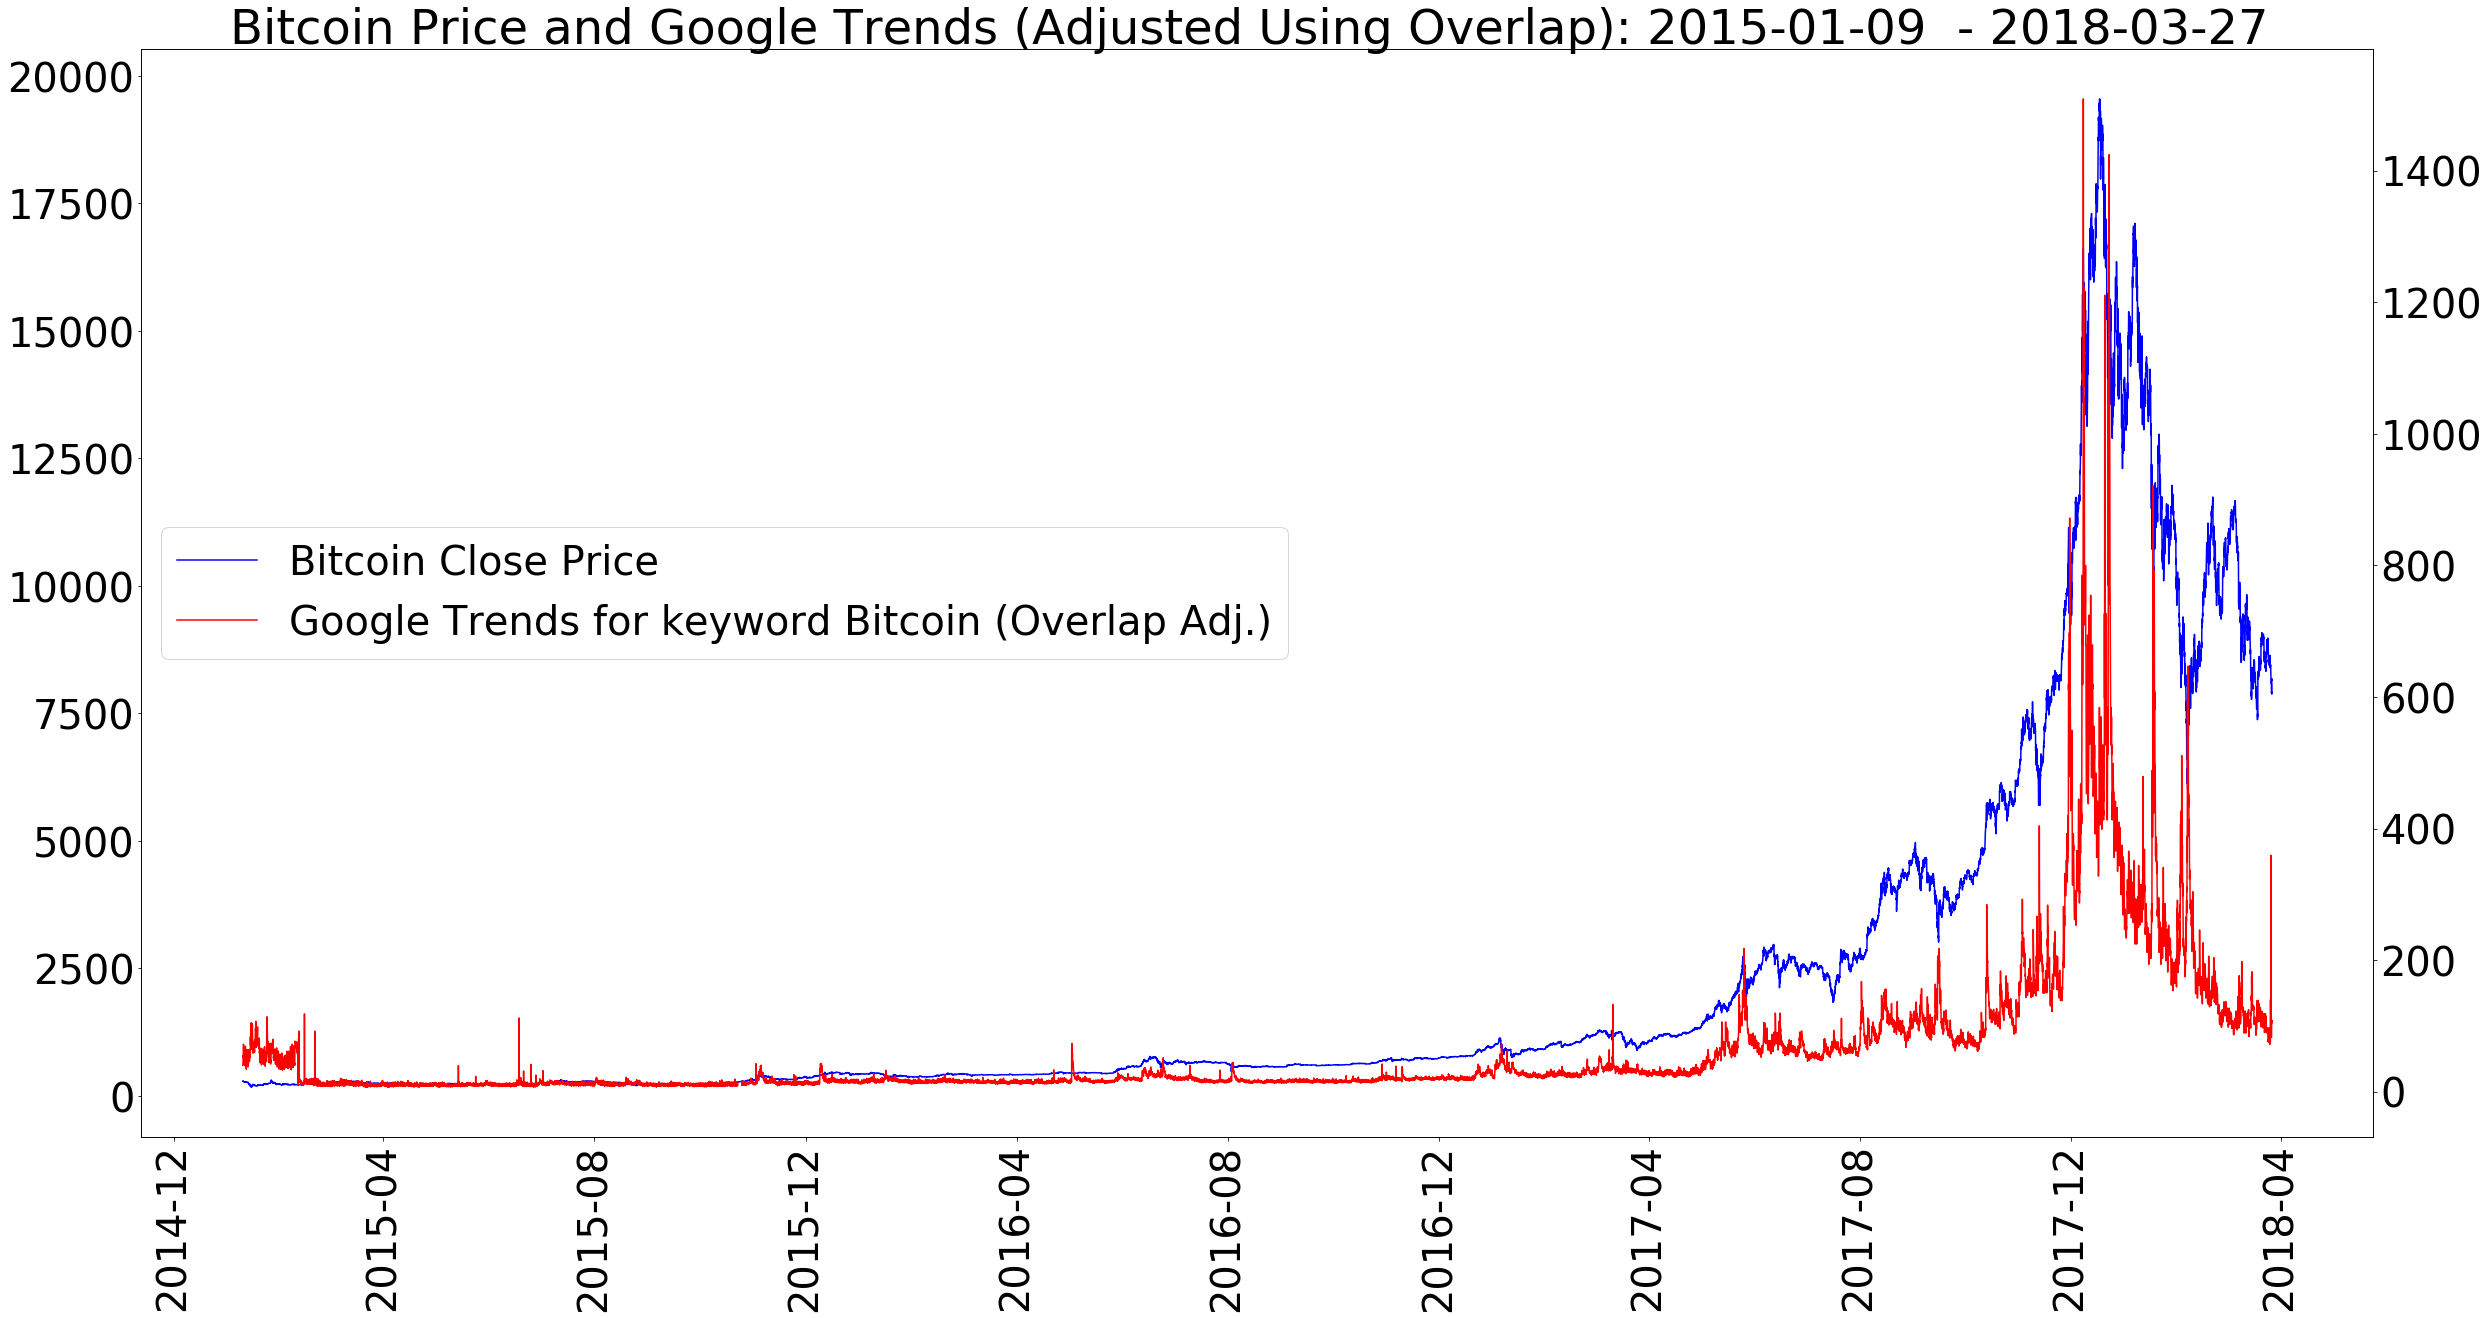

In [66]:
import matplotlib.pyplot as plt

btc_and_trends_df_hourly_overlap = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_overlap_df, right_on="Timestamp")
#display(btc_and_trends_df_hourly_overlap.head(2))

fig_bitcoin_overlap, ax_bitcoin_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_overlap.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close"], color='blue')
ax_bitcoin_overlap_2 = ax_bitcoin_overlap.twinx() 
l2, = ax_bitcoin_overlap_2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_overlap.set_title('Bitcoin Price and Google Trends (Adjusted Using Overlap): ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overlap.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 40})

# ax_bitcoin_overlap.legend(['Google Trends for keyword Bitcoin (Overlap Adj.)'])
# ax_bitcoin_overlap.legend(['Google Trends for keyword Bitcoin (Overlap Adj.)'])
#ax_bitcoin_overlap.legend()
#ax_bitcoin_overlap_2.legend()
plt.legend([l1, l2],["Bitcoin Close Price", "Google Trends: Bitcoin (Overlap Adj.)" ], loc=6)
plt.show();



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date(UTC),date,Bitcoin,Ethereum,Bitstamp,Buy Bitcoin,Coinbase,isPartial,Date_UTC_trend,Bitcoin (Adj.)
0,1420840800,289.59,289.94,289.13,289.13,34.042422,9854.490388,289.476771,2015-01-09 22:00:00,2015-01-09 12:00:00,40,0,6,1,1,False,2015-01-09 17:00:00+00:00,100.0
1,1420844400,293.61,293.61,292.15,292.15,36.628012,10733.474257,293.040042,2015-01-09 23:00:00,2015-01-09 13:00:00,41,0,6,1,1,False,2015-01-09 18:00:00+00:00,102.5
2,1420848000,293.89,293.89,293.89,293.89,0.158015,46.439149,293.890000,2015-01-10 00:00:00,2015-01-09 14:00:00,43,0,6,1,1,False,2015-01-09 19:00:00+00:00,107.5
3,1420851600,289.20,289.20,289.10,289.10,30.985828,8960.344674,289.175573,2015-01-10 01:00:00,2015-01-09 15:00:00,43,0,6,1,1,False,2015-01-09 20:00:00+00:00,107.5
4,1420855200,289.18,289.18,288.57,288.59,7.694195,2224.105007,289.062740,2015-01-10 02:00:00,2015-01-09 16:00:00,45,0,5,1,1,False,2015-01-09 21:00:00+00:00,112.5


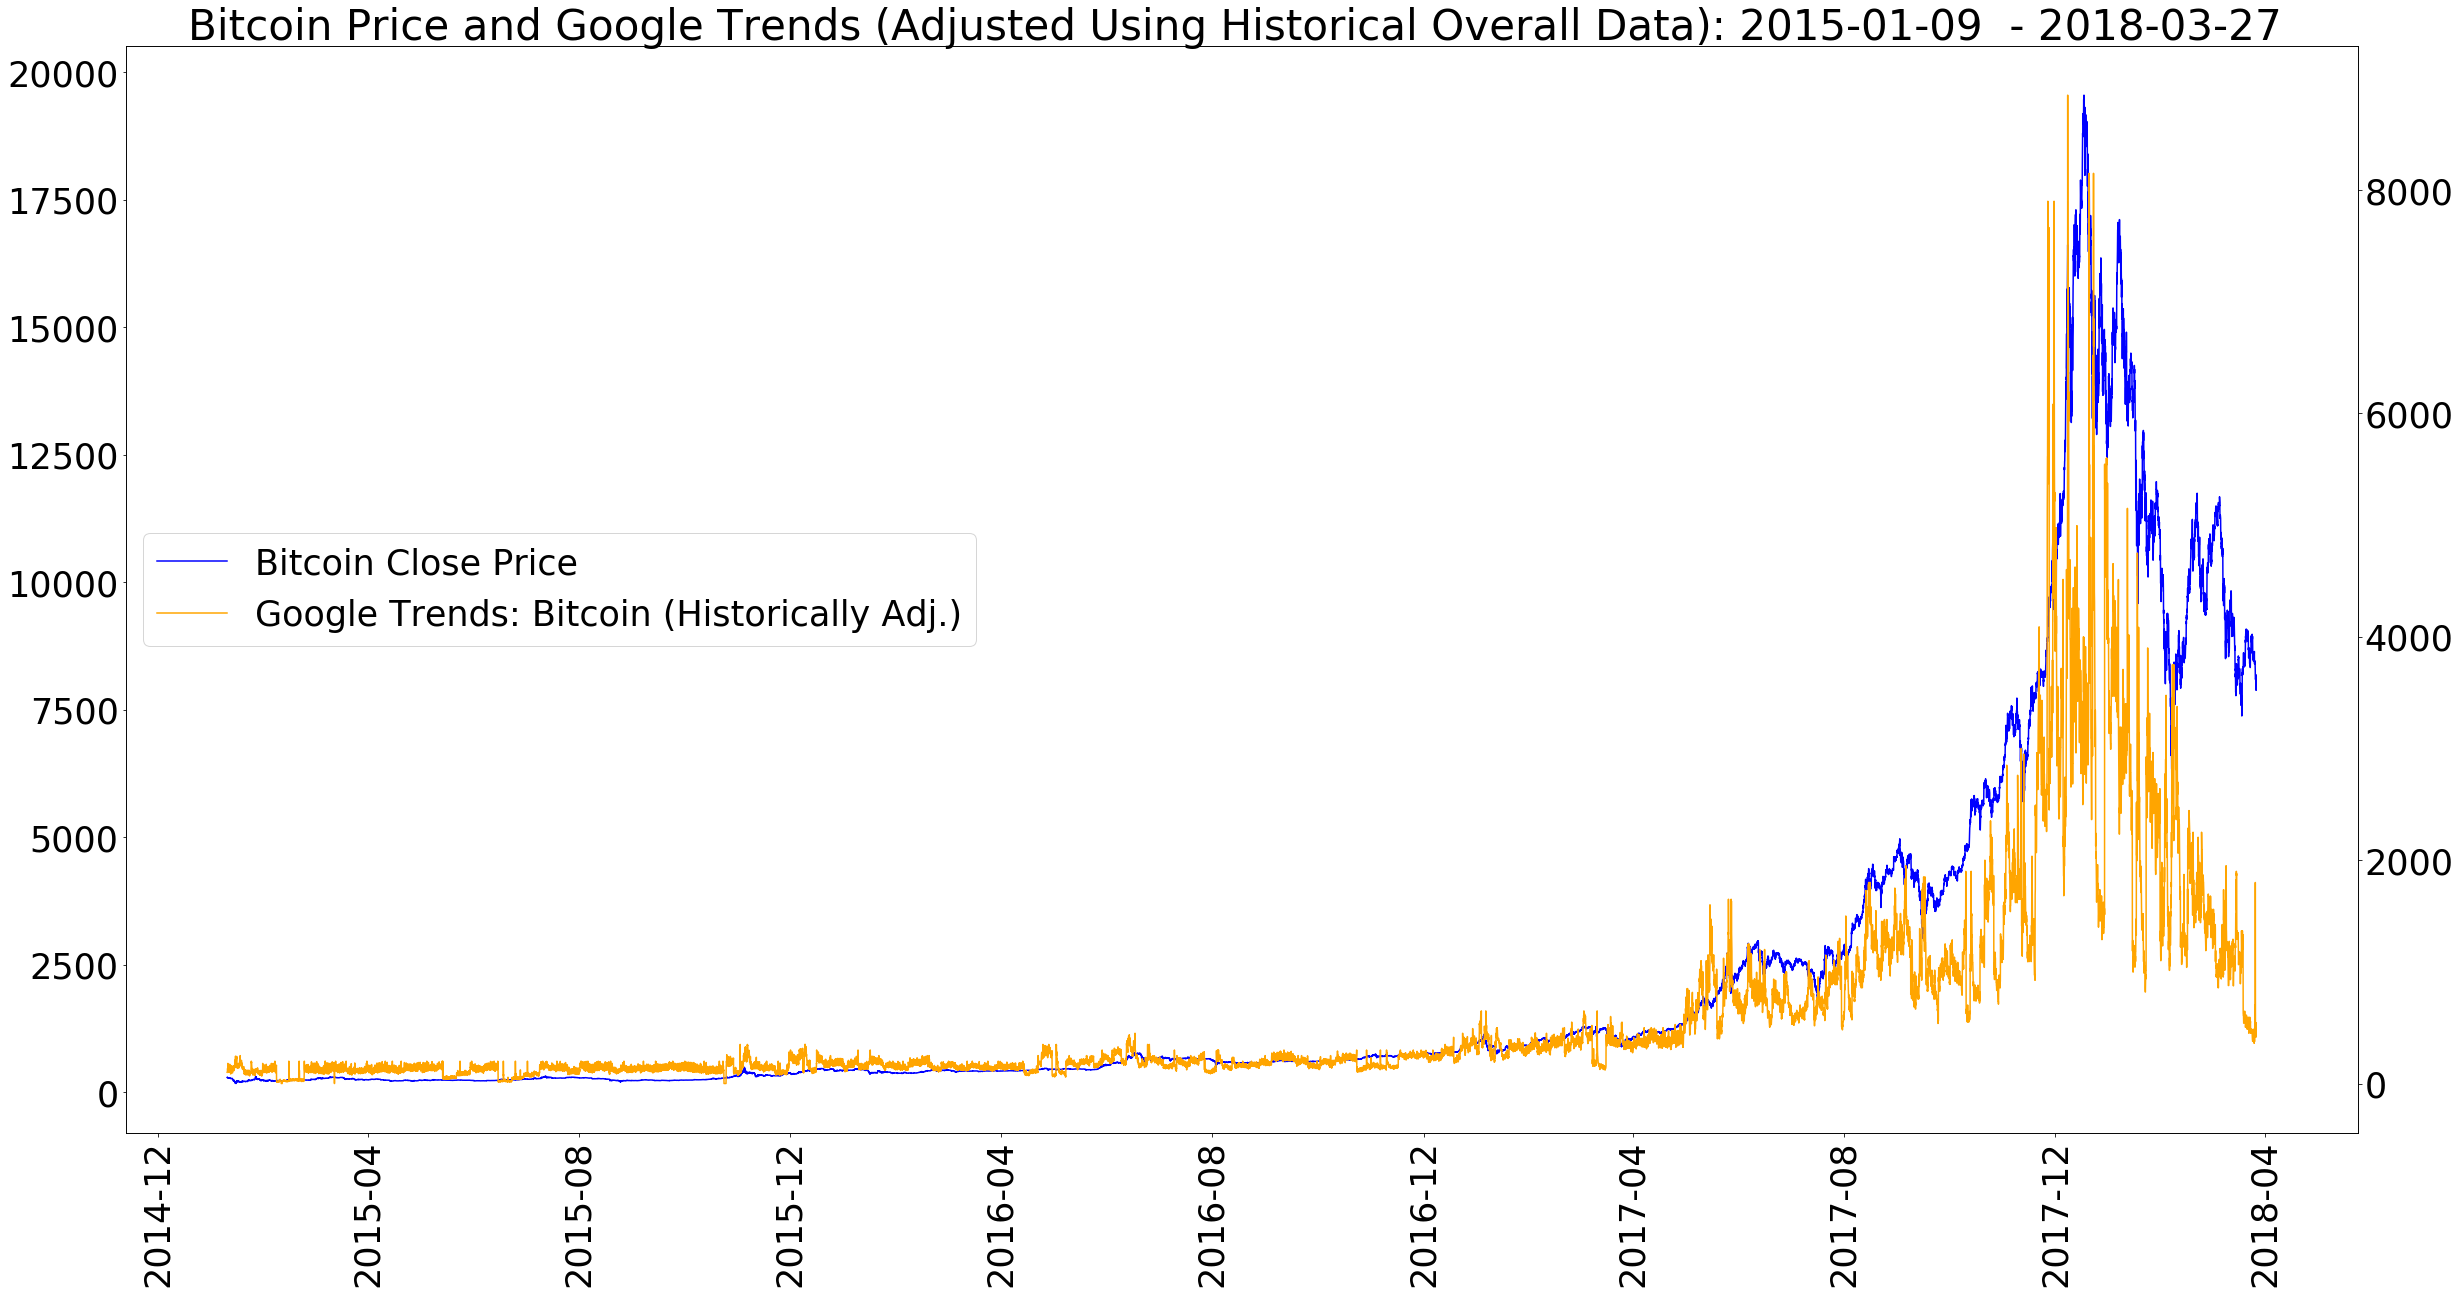

In [72]:
# TODO: Investigate if this is merged correctly or not
btc_and_trends_df_hourly = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_df, right_on="Timestamp")
display(btc_and_trends_df_hourly.head())

fig_bitcoin_overall, ax_bitcoin_overall = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_overall.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Close"], color='blue')
ax_bitcoin_overall_2 = ax_bitcoin_overall.twinx() 
l2, = ax_bitcoin_overall_2.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Bitcoin (Adj.)"], color='orange' )
ax_bitcoin_overall.set_title('Bitcoin Price and Google Trends (Adjusted Using Historical Overall Data): ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overall.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Bitcoin Close Price", "Google Trends: Bitcoin (Historically Adj.)"], loc=6)
plt.show();


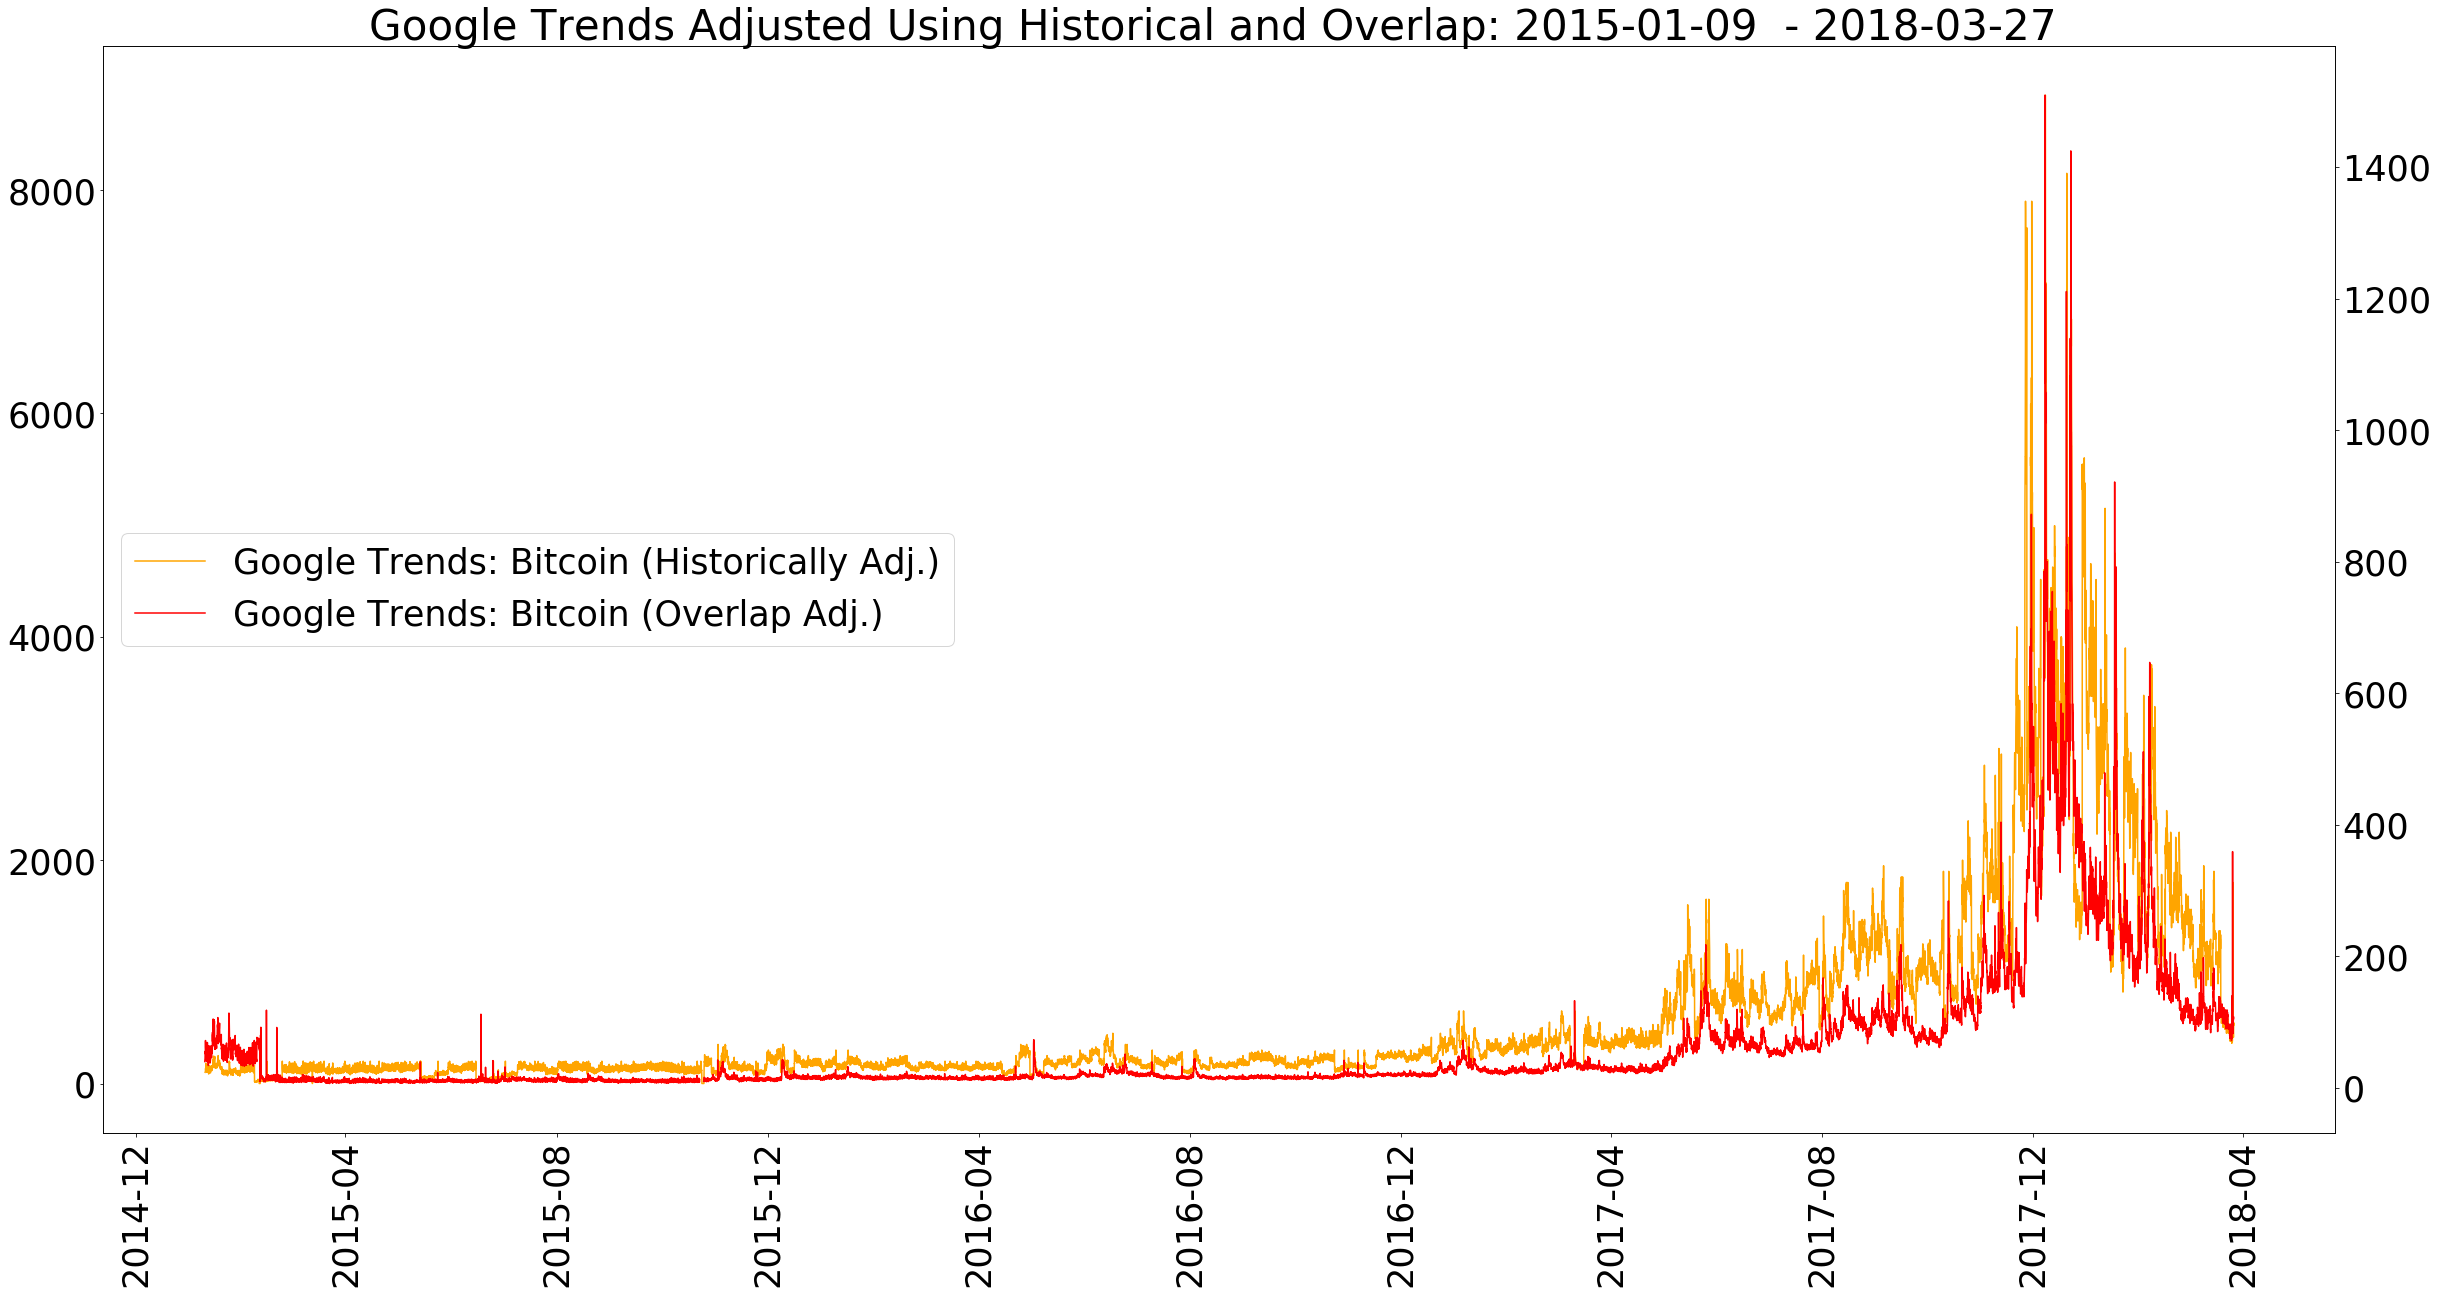

In [73]:
# Graph both historical adjustment and overlap adjustment 
fig_historical_and_overlap, ax_historical_and_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_historical_and_overlap.plot(btc_and_trends_df_hourly["Date(UTC)"], btc_and_trends_df_hourly["Bitcoin (Adj.)"], color='orange')
ax_historical_and_overlap_2 = ax_historical_and_overlap.twinx() 
l2, = ax_historical_and_overlap_2.plot(btc_and_trends_df_hourly_overlap['Date_UTC_trend'], btc_and_trends_df_hourly_overlap["Bitcoin (Adj.Overlap)"], color='red' )
ax_historical_and_overlap.set_title('Google Trends Adjusted Using Historical and Overlap: ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_historical_and_overlap.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 35})
plt.legend([l1, l2],["Google Trends: Bitcoin (Historically Adj.)", "Google Trends: Bitcoin (Overlap Adj.)"], loc=6)
plt.show();


# Orange is Historically adjusted and Red is Overlap adjusted

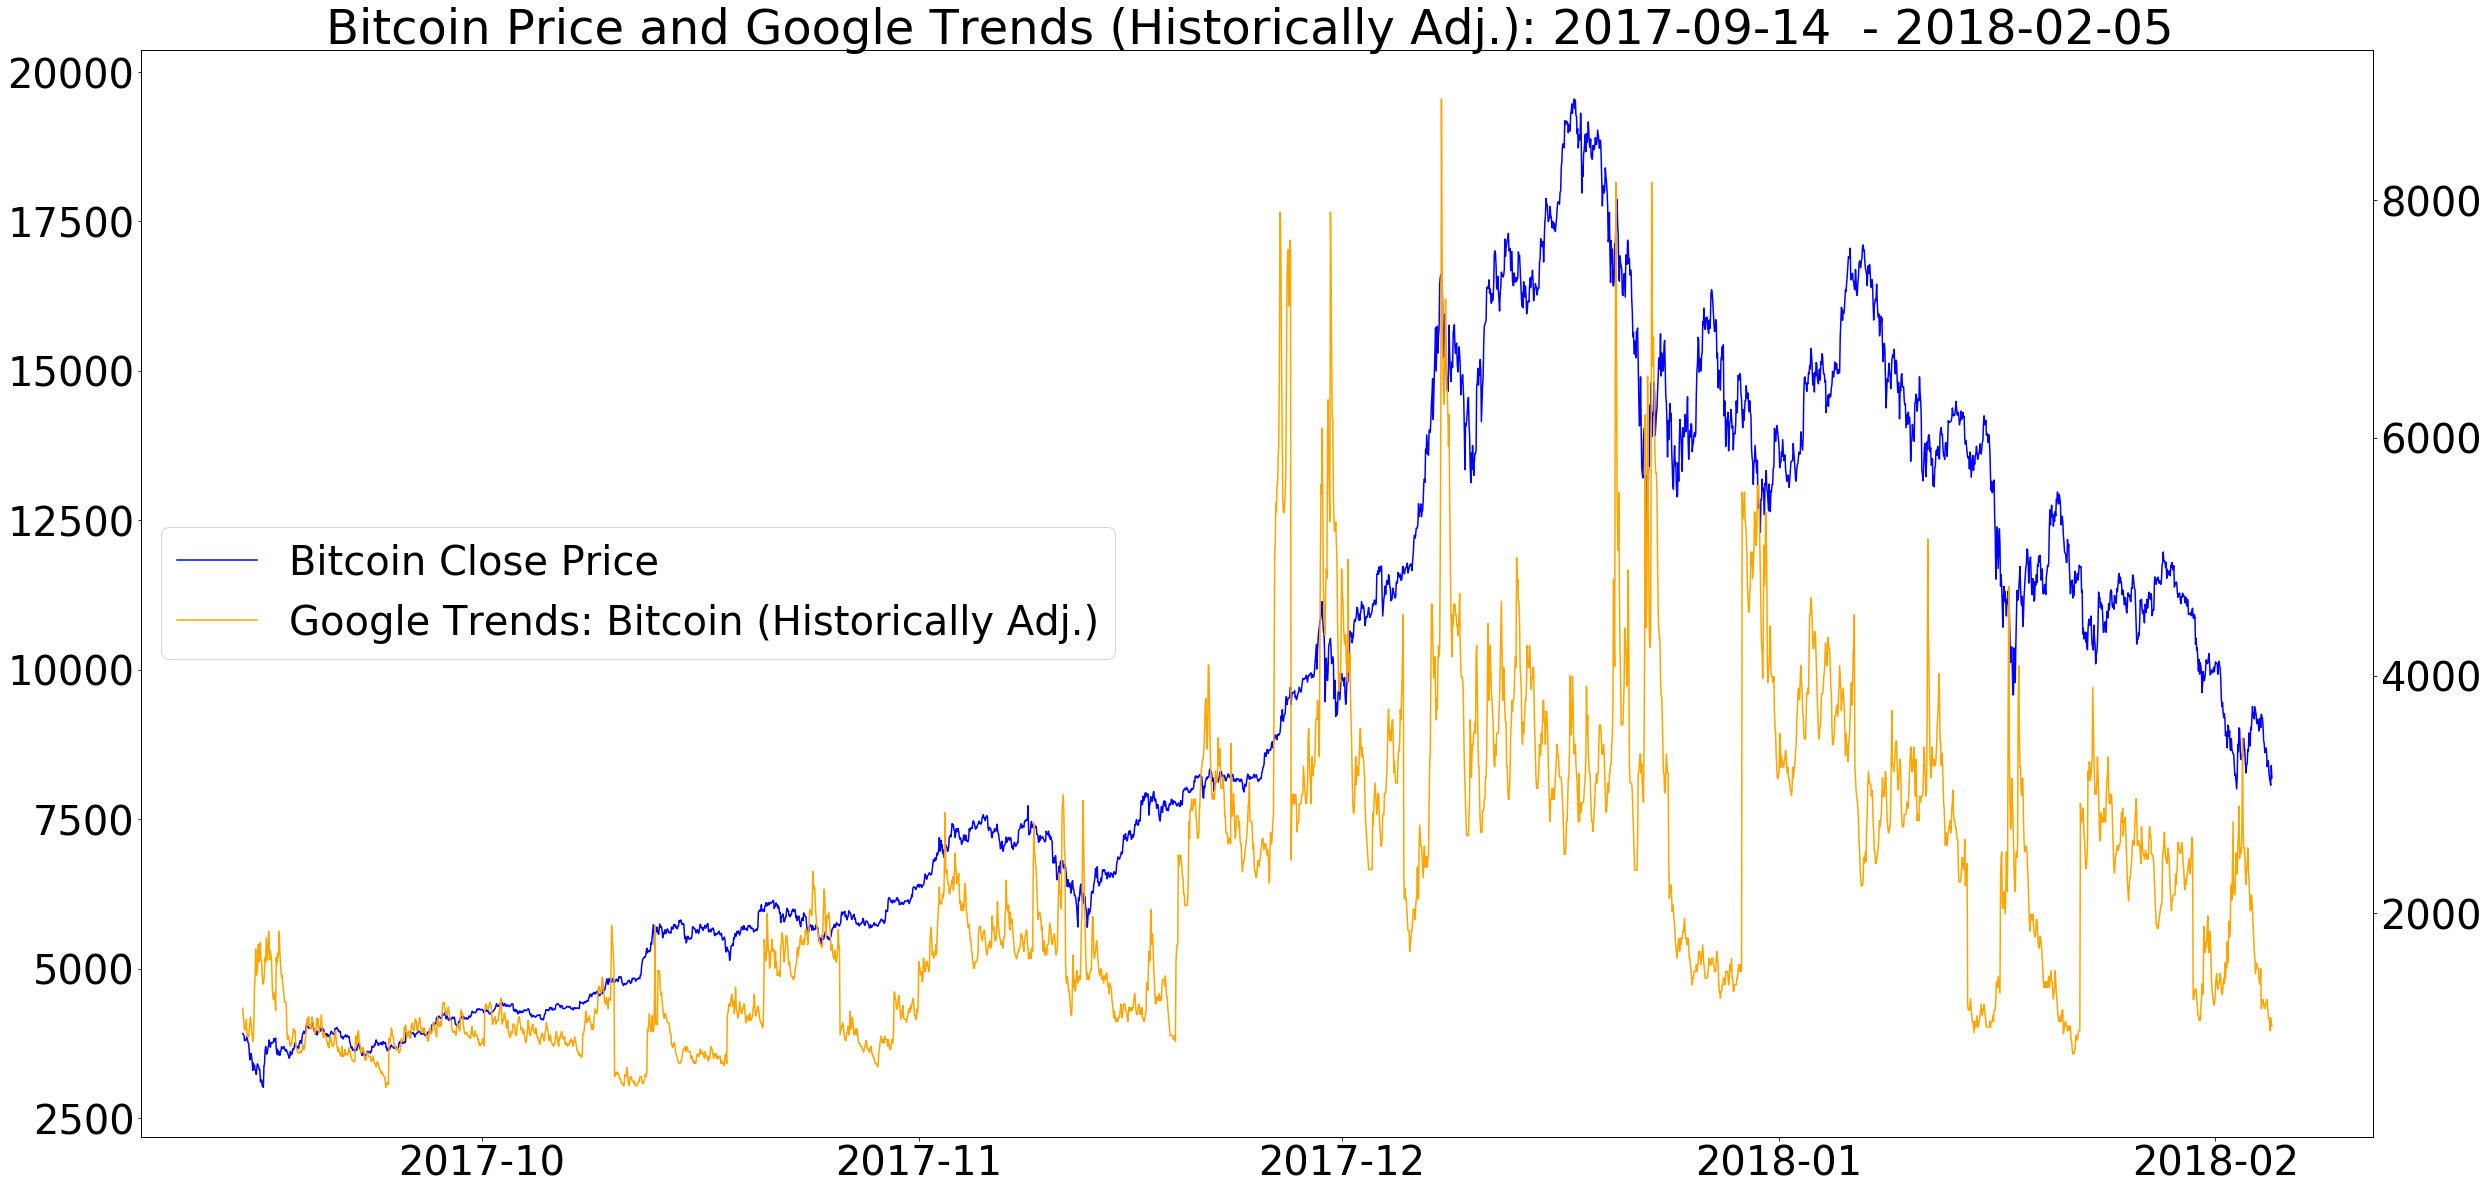

In [78]:
# visualize Bitcoin's recent super spike starting Sep 2017 using Historically Adjusted Trend Data

sep_2017_to_feb_2018_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > 1505347200) & (btc_and_trends_df_hourly["Timestamp"] <=  1517788800) ]
sep_2017_to_feb_2018_overlap_df = btc_and_trends_df_hourly_overlap[ (btc_and_trends_df_hourly_overlap["Timestamp"] > 1505347200) & (btc_and_trends_df_hourly_overlap["Timestamp"] <=  1517788800) ]

fig_bitcoin_spike, ax_bitcoin_spike = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_spike.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Close"], color='blue')
ax_bitcoin_spike_2 = ax_bitcoin_spike.twinx() 
l2, = ax_bitcoin_spike_2.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Bitcoin (Adj.)"], color='orange' )

ax_bitcoin_spike.set_title('Bitcoin Price and Google Trends (Historically Adj.): ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overall.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 40})

plt.legend([l1, l2],["Bitcoin Close Price", "Google Trends: Bitcoin (Historically Adj.)"], loc=6)

plt.show();

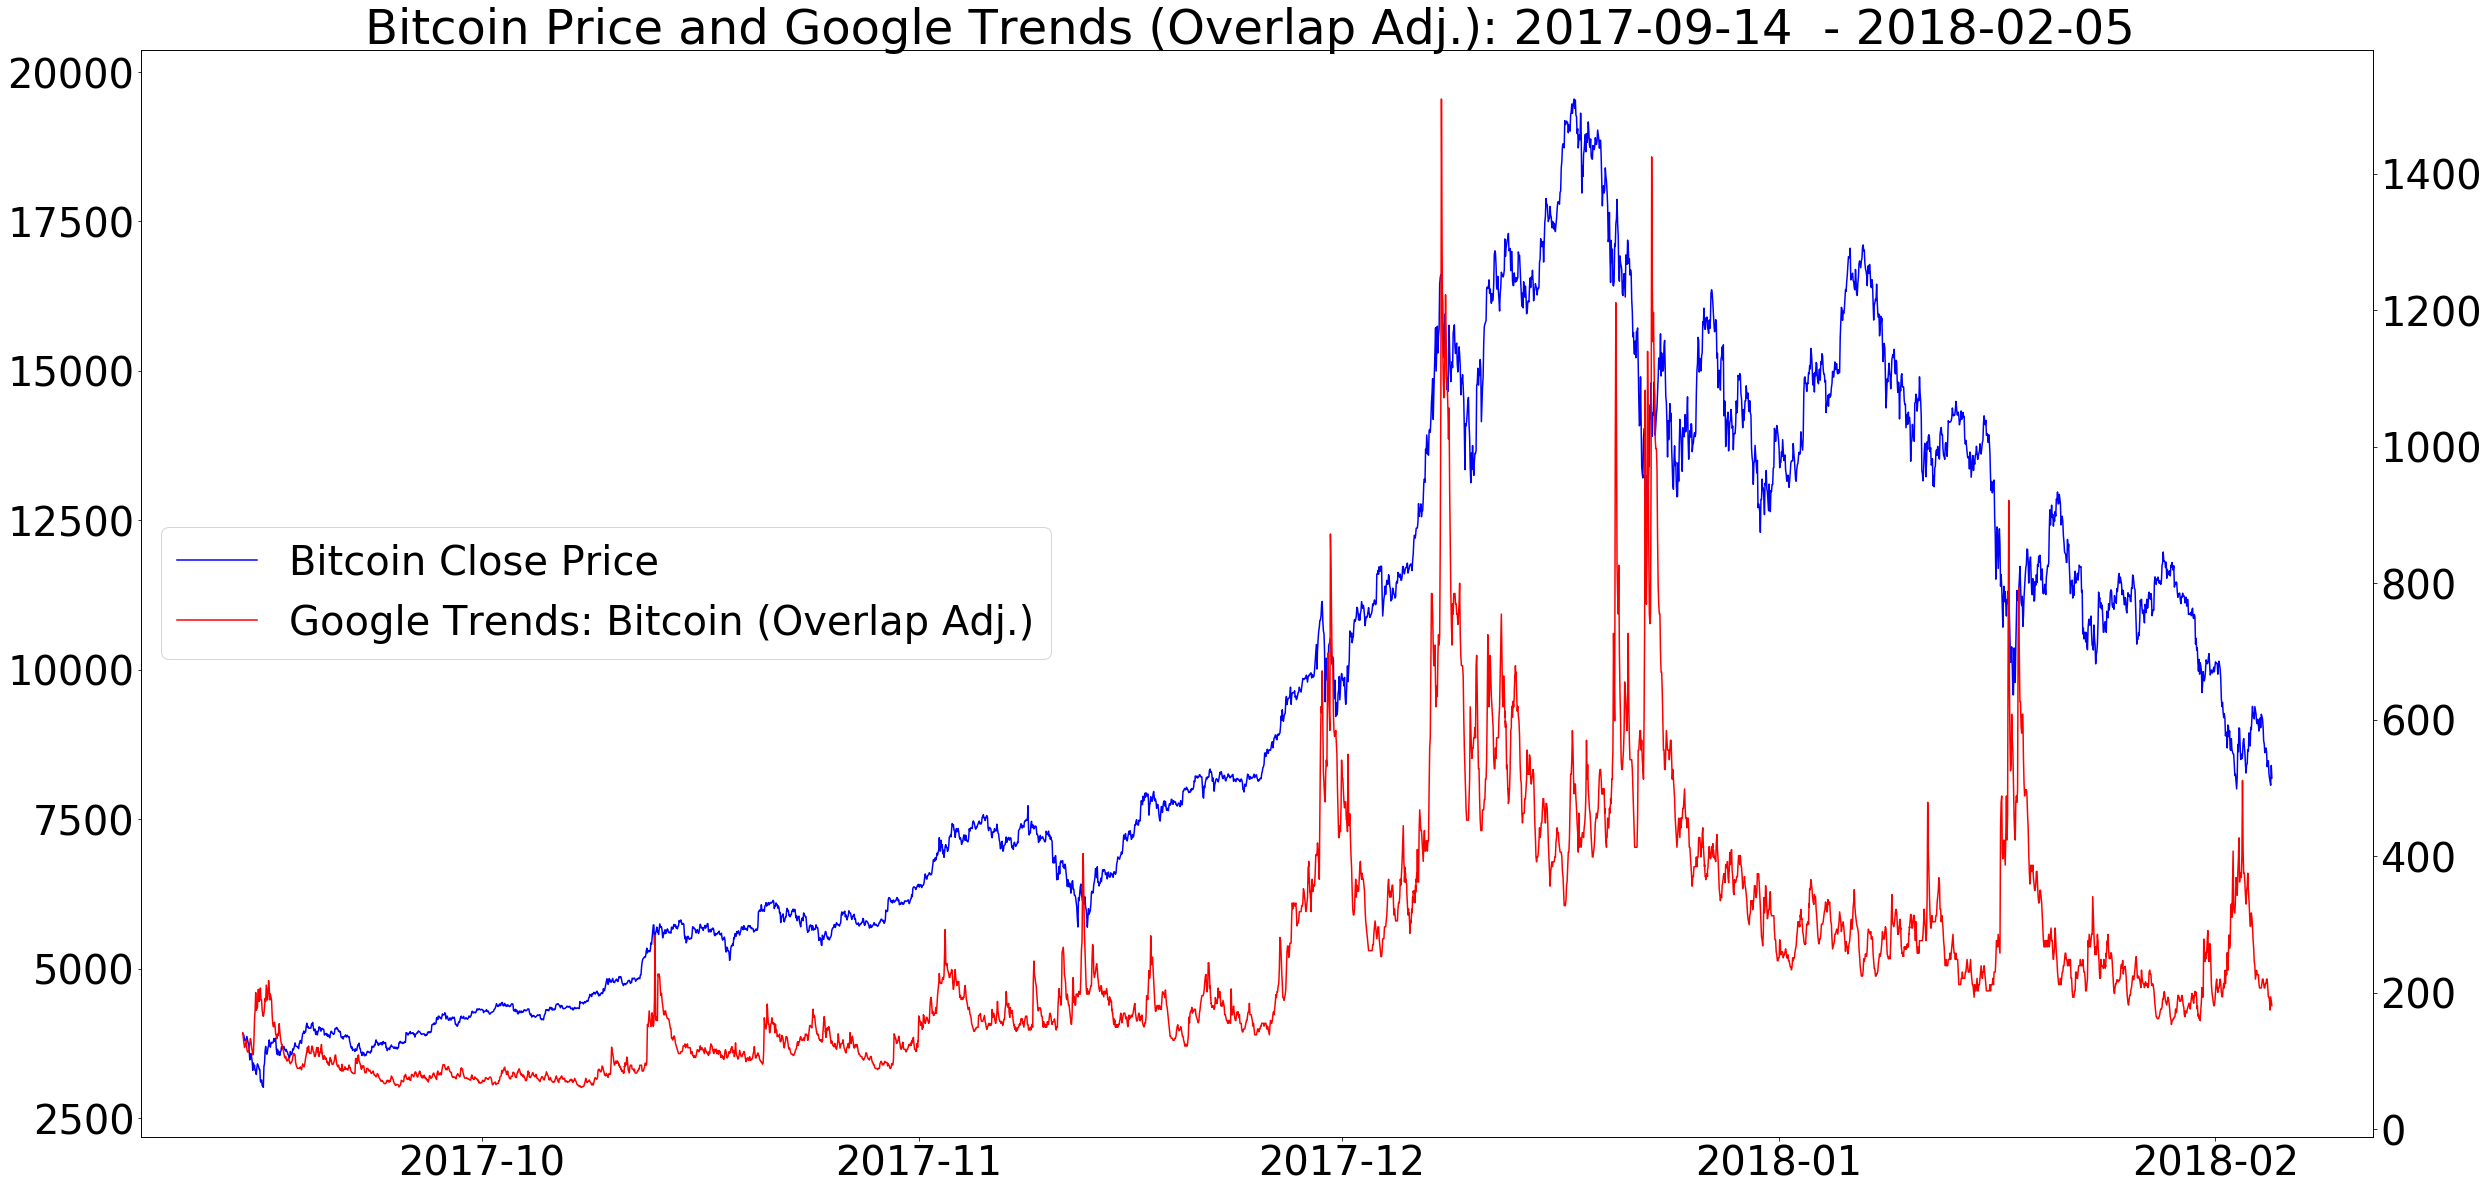

In [77]:
# visualize Bitcoin's recent super spike starting Sep 2017 using Overlap Adjusted Trend Data

fig_bitcoin_spike_overlap, ax_bitcoin_spike_overlap = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_spike_overlap.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Close"], color='blue')
ax_bitcoin_spike_overlap_2 = ax_bitcoin_spike_overlap.twinx() 
l2, = ax_bitcoin_spike_overlap_2.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Bitcoin (Adj.Overlap)"], color='red' )
ax_bitcoin_spike_overlap.set_title('Bitcoin Price and Google Trends (Overlap Adj.): ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_overlap_df["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overlap.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 40})
plt.legend([l1, l2],["Bitcoin Close Price", "Google Trends: Bitcoin (Overlap Adj.)"], loc=6)
plt.show();

# blue is price, red is Overlap adjusted data

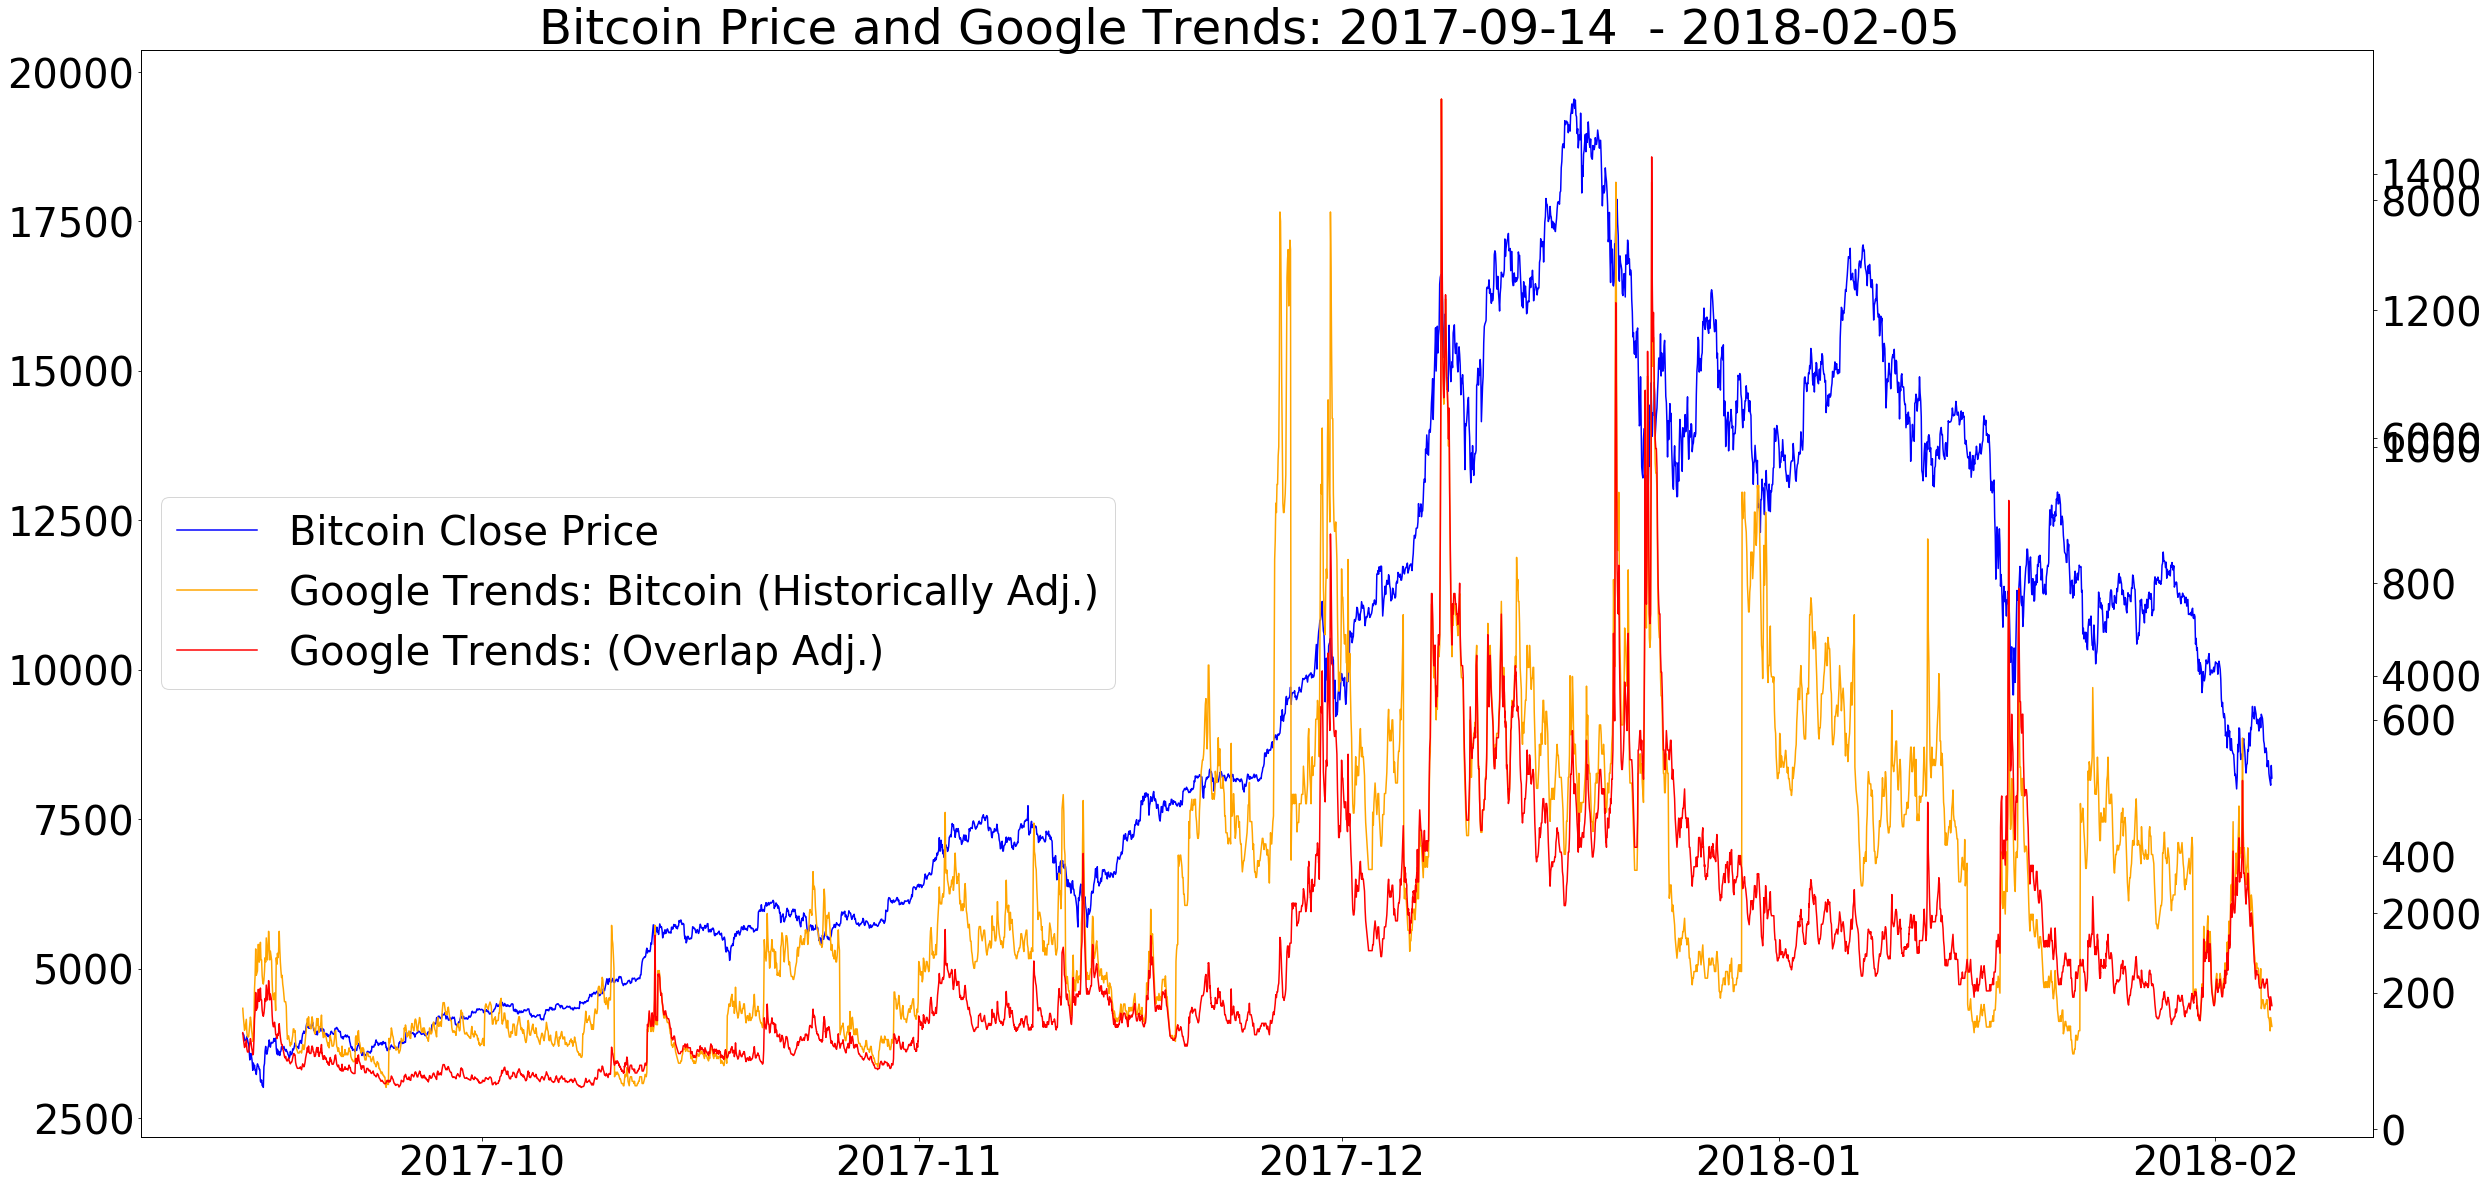

In [76]:
# plot both historically adjusted and overlap adjusted 

fig_bitcoin_spike, ax_bitcoin_spike = plt.subplots(figsize=(40,20)) 
l1, = ax_bitcoin_spike.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Close"], color='blue')
ax_bitcoin_spike_2 = ax_bitcoin_spike.twinx() 
l2, = ax_bitcoin_spike_2.plot(sep_2017_to_feb_2018_df["Date(UTC)"], sep_2017_to_feb_2018_df["Bitcoin (Adj.)"], color='orange' )

ax_bitcoin_spike_overlap_3 = ax_bitcoin_spike.twinx() 
l3, = ax_bitcoin_spike_overlap_3.plot(sep_2017_to_feb_2018_overlap_df["Date(UTC)"], sep_2017_to_feb_2018_overlap_df["Bitcoin (Adj.Overlap)"], color='red' )

ax_bitcoin_spike.set_title('Bitcoin Price and Google Trends: ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(sep_2017_to_feb_2018_df["Date(UTC)"].iloc[-1])[:-8] )
for tick in ax_bitcoin_overall.get_xticklabels():
    tick.set_rotation(90)
plt.rcParams.update({'font.size': 40})

plt.legend([l1, l2, l3],["Bitcoin Close Price", "Google Trends: Bitcoin (Historically Adj.)", "Google Trends: (Overlap Adj.)"], loc=6)

plt.show();

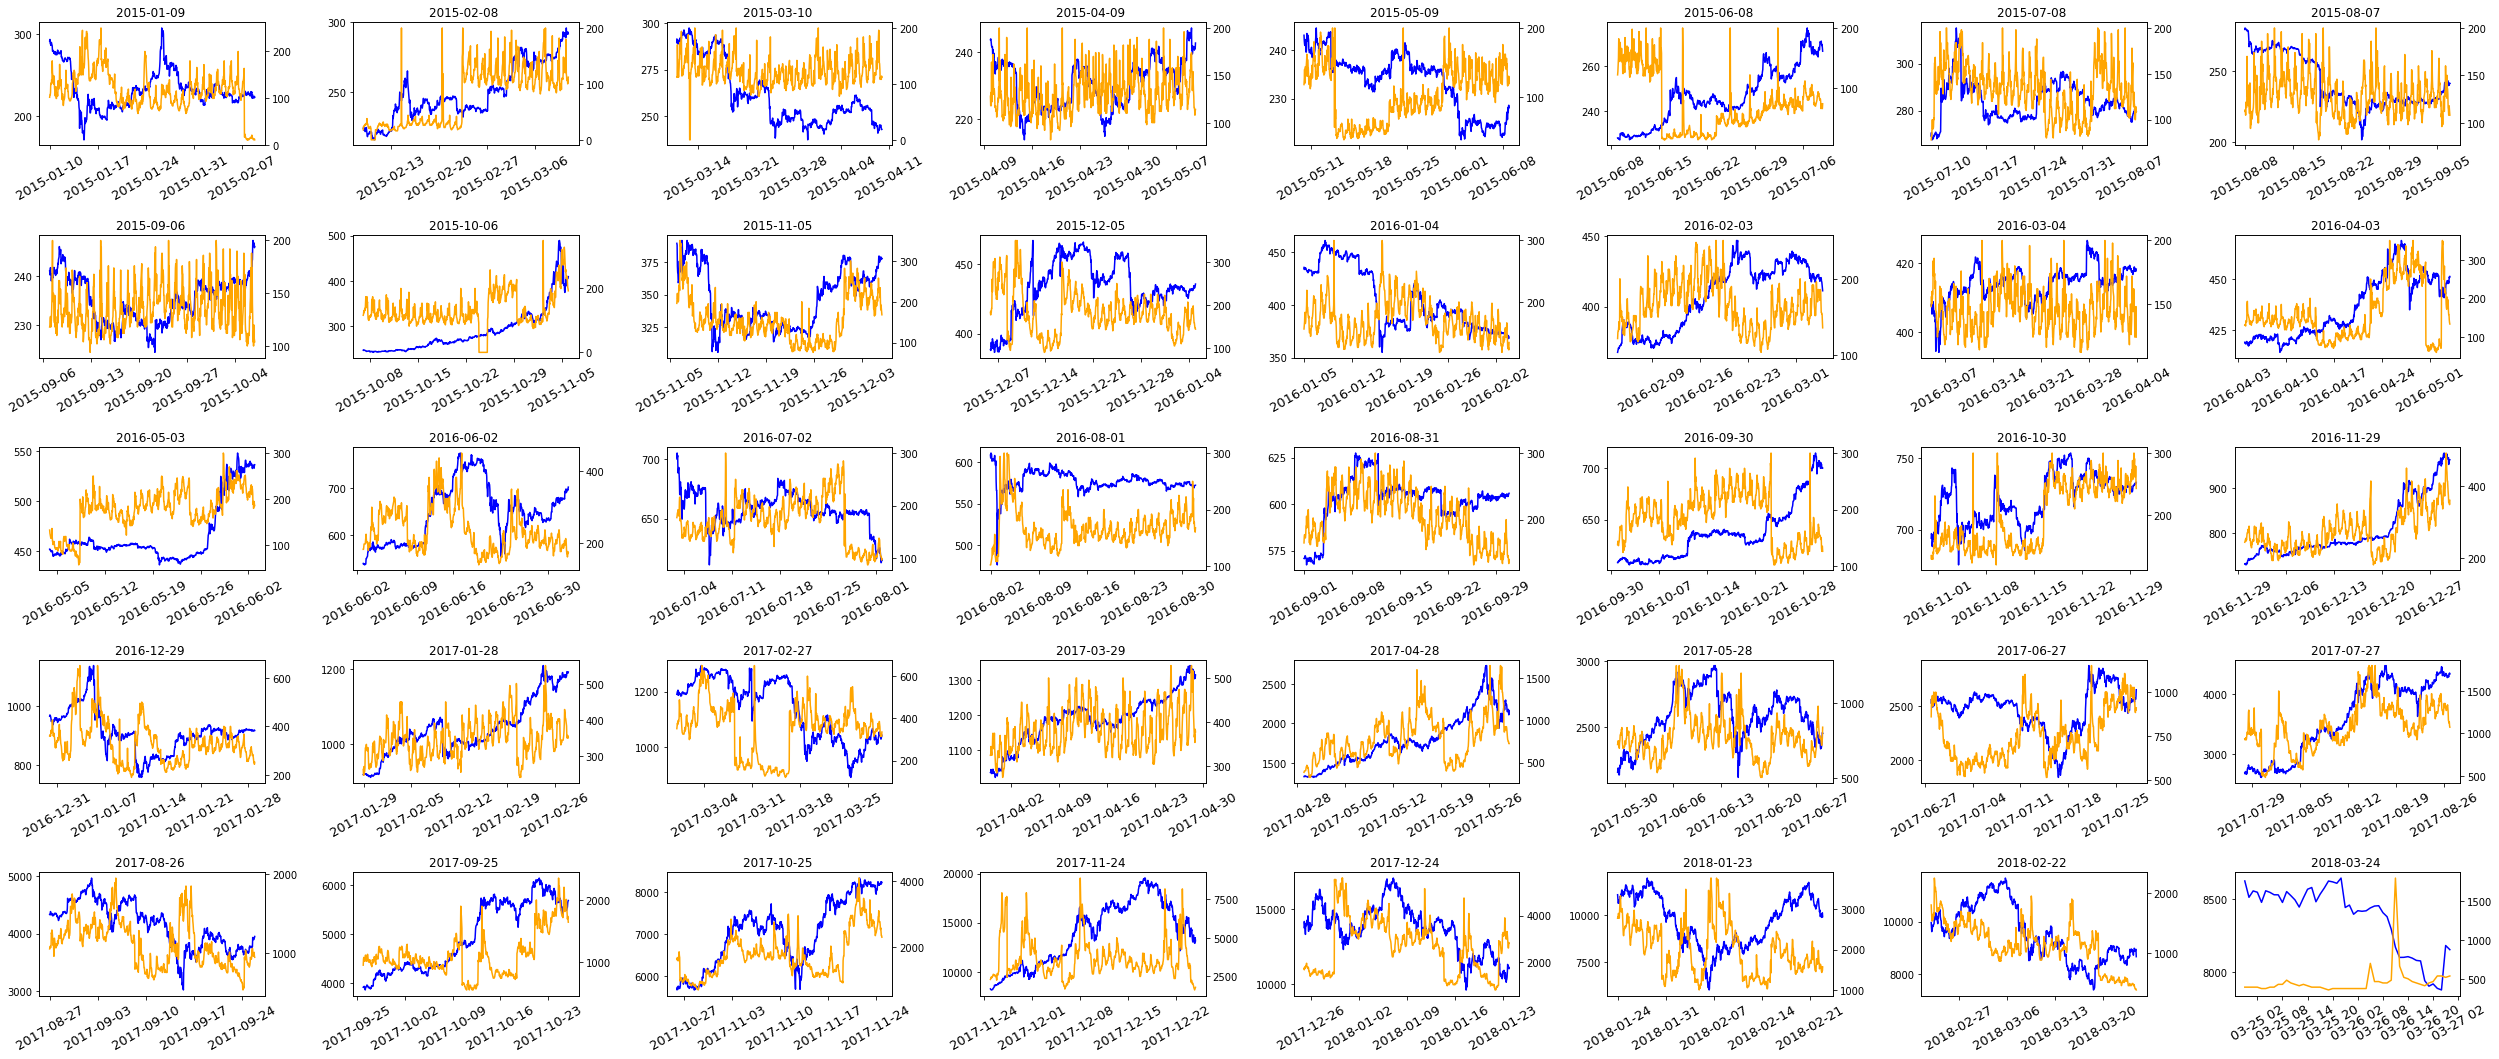

In [60]:
# from sklearn import preprocessing
# min_max_scaler=preprocessing.MinMaxScaler()

#change so that it just creates a new column

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = btc_and_trends_df_hourly[['Close','Bitcoin']]

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = min_max_scaler.fit_transform(btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']])
# btc_and_trends_df_hourly.head()

# fig, ax = plt.subplots()
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["close_normalized"])
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["bitcoin_normalized"])
# ax.set_title("Bitcoin Close Prices and Google Trends Normalized")
# ax.set(ylabel="price and trend, scaled to 0-1",xlabel="time")
# plt.show()

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(35,15), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin (Adj.)"], color='orange' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8])
    start_timestamp += 2592000
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
        tick.set_fontsize(13)
        
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     labels_modified = [label[5:] for label in labels] 
#     ax.set_xticklabels(labels_modified)
        
#         tick_label = tick.get_text()
#         display(tick_label)
#         tick.set_text(tick_label[5:]) Doesnt work!
    
plt.rcParams.update({'font.size': 16})
fig.tight_layout()
plt.show();

# Orange is Google Trends Hourly Data for the keyword 'Bitcoin'
# Blue is Bitcoin Hourly Close Data 

In [65]:
from luminol.anomaly_detector import AnomalyDetector 
from luminol.correlator import Correlator

# Convert dataframe into dictionary to put into luminol
timestamp_close_df = btc_and_trends_df_hourly[['Timestamp', 'Close']]
timestamp_bitcoin_trend_df = btc_and_trends_df_hourly[['Timestamp', "Bitcoin (Adj.)"]]
display(timestamp_close_df.head())
display(timestamp_bitcoin_trend_df.head())

timestamp_close_dict = timestamp_close_df.set_index('Timestamp')['Close'].to_dict()
timestamp_bitcoin_trend_dict = timestamp_bitcoin_trend_df.set_index('Timestamp')["Bitcoin (Adj.)"].to_dict()

# anomaly detector 
anomaly_detector = AnomalyDetector(timestamp_close_dict)
score = anomaly_detector.get_all_scores()

anomaly_df = pd.DataFrame(columns=['Timestamp', 'Date', 'Anomaly Score'])

for timestamp, value in score.iteritems():
    # print anomaly score if greater than 0 
    if (value > 0 ):
        readable_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H')
        #display( str(readable_date) + '->' + str(value))
        anomaly_df = anomaly_df.append({'Timestamp':timestamp, 'Date': readable_date, 'Anomaly Score': value}, ignore_index=True)
# correlate Close price and Google Trends
anomalies = anomaly_detector.get_anomalies()
for anomaly in anomalies:
    time_period = anomaly.get_time_window()
    
    # to do: tweek the parameters for correlator (like the shift allowed)
    correlator = Correlator(timestamp_close_dict, timestamp_bitcoin_trend_dict, time_period)
    if correlator.is_correlated(threshold=0.5):
        display("Trend data correlate with Price at time period (%d, %d)" % time_period)

display('There were '+ str(len(anomalies))+ ' anomalies')

display(anomaly_df.head())

,Timestamp,Close
0,1420840800,289.13
1,1420844400,292.15
2,1420848000,293.89
3,1420851600,289.10
4,1420855200,288.59


,Timestamp,Bitcoin (Adj.)
0,1420840800,100.0
1,1420844400,102.5
2,1420848000,107.5
3,1420851600,107.5
4,1420855200,112.5


'Trend data correlate with Price at time period (1512424800, 1513144800)'

'Trend data correlate with Price at time period (1514775600, 1514952000)'

'Trend data correlate with Price at time period (1518325200, 1518922800)'

'There were 9 anomalies'

,Timestamp,Date,Anomaly Score
0,1507100400,2017-10-04 03,86.0
1,1507104000,2017-10-04 04,114.0
2,1507107600,2017-10-04 05,146.0
3,1507111200,2017-10-04 06,182.0
4,1507114800,2017-10-04 07,222.0


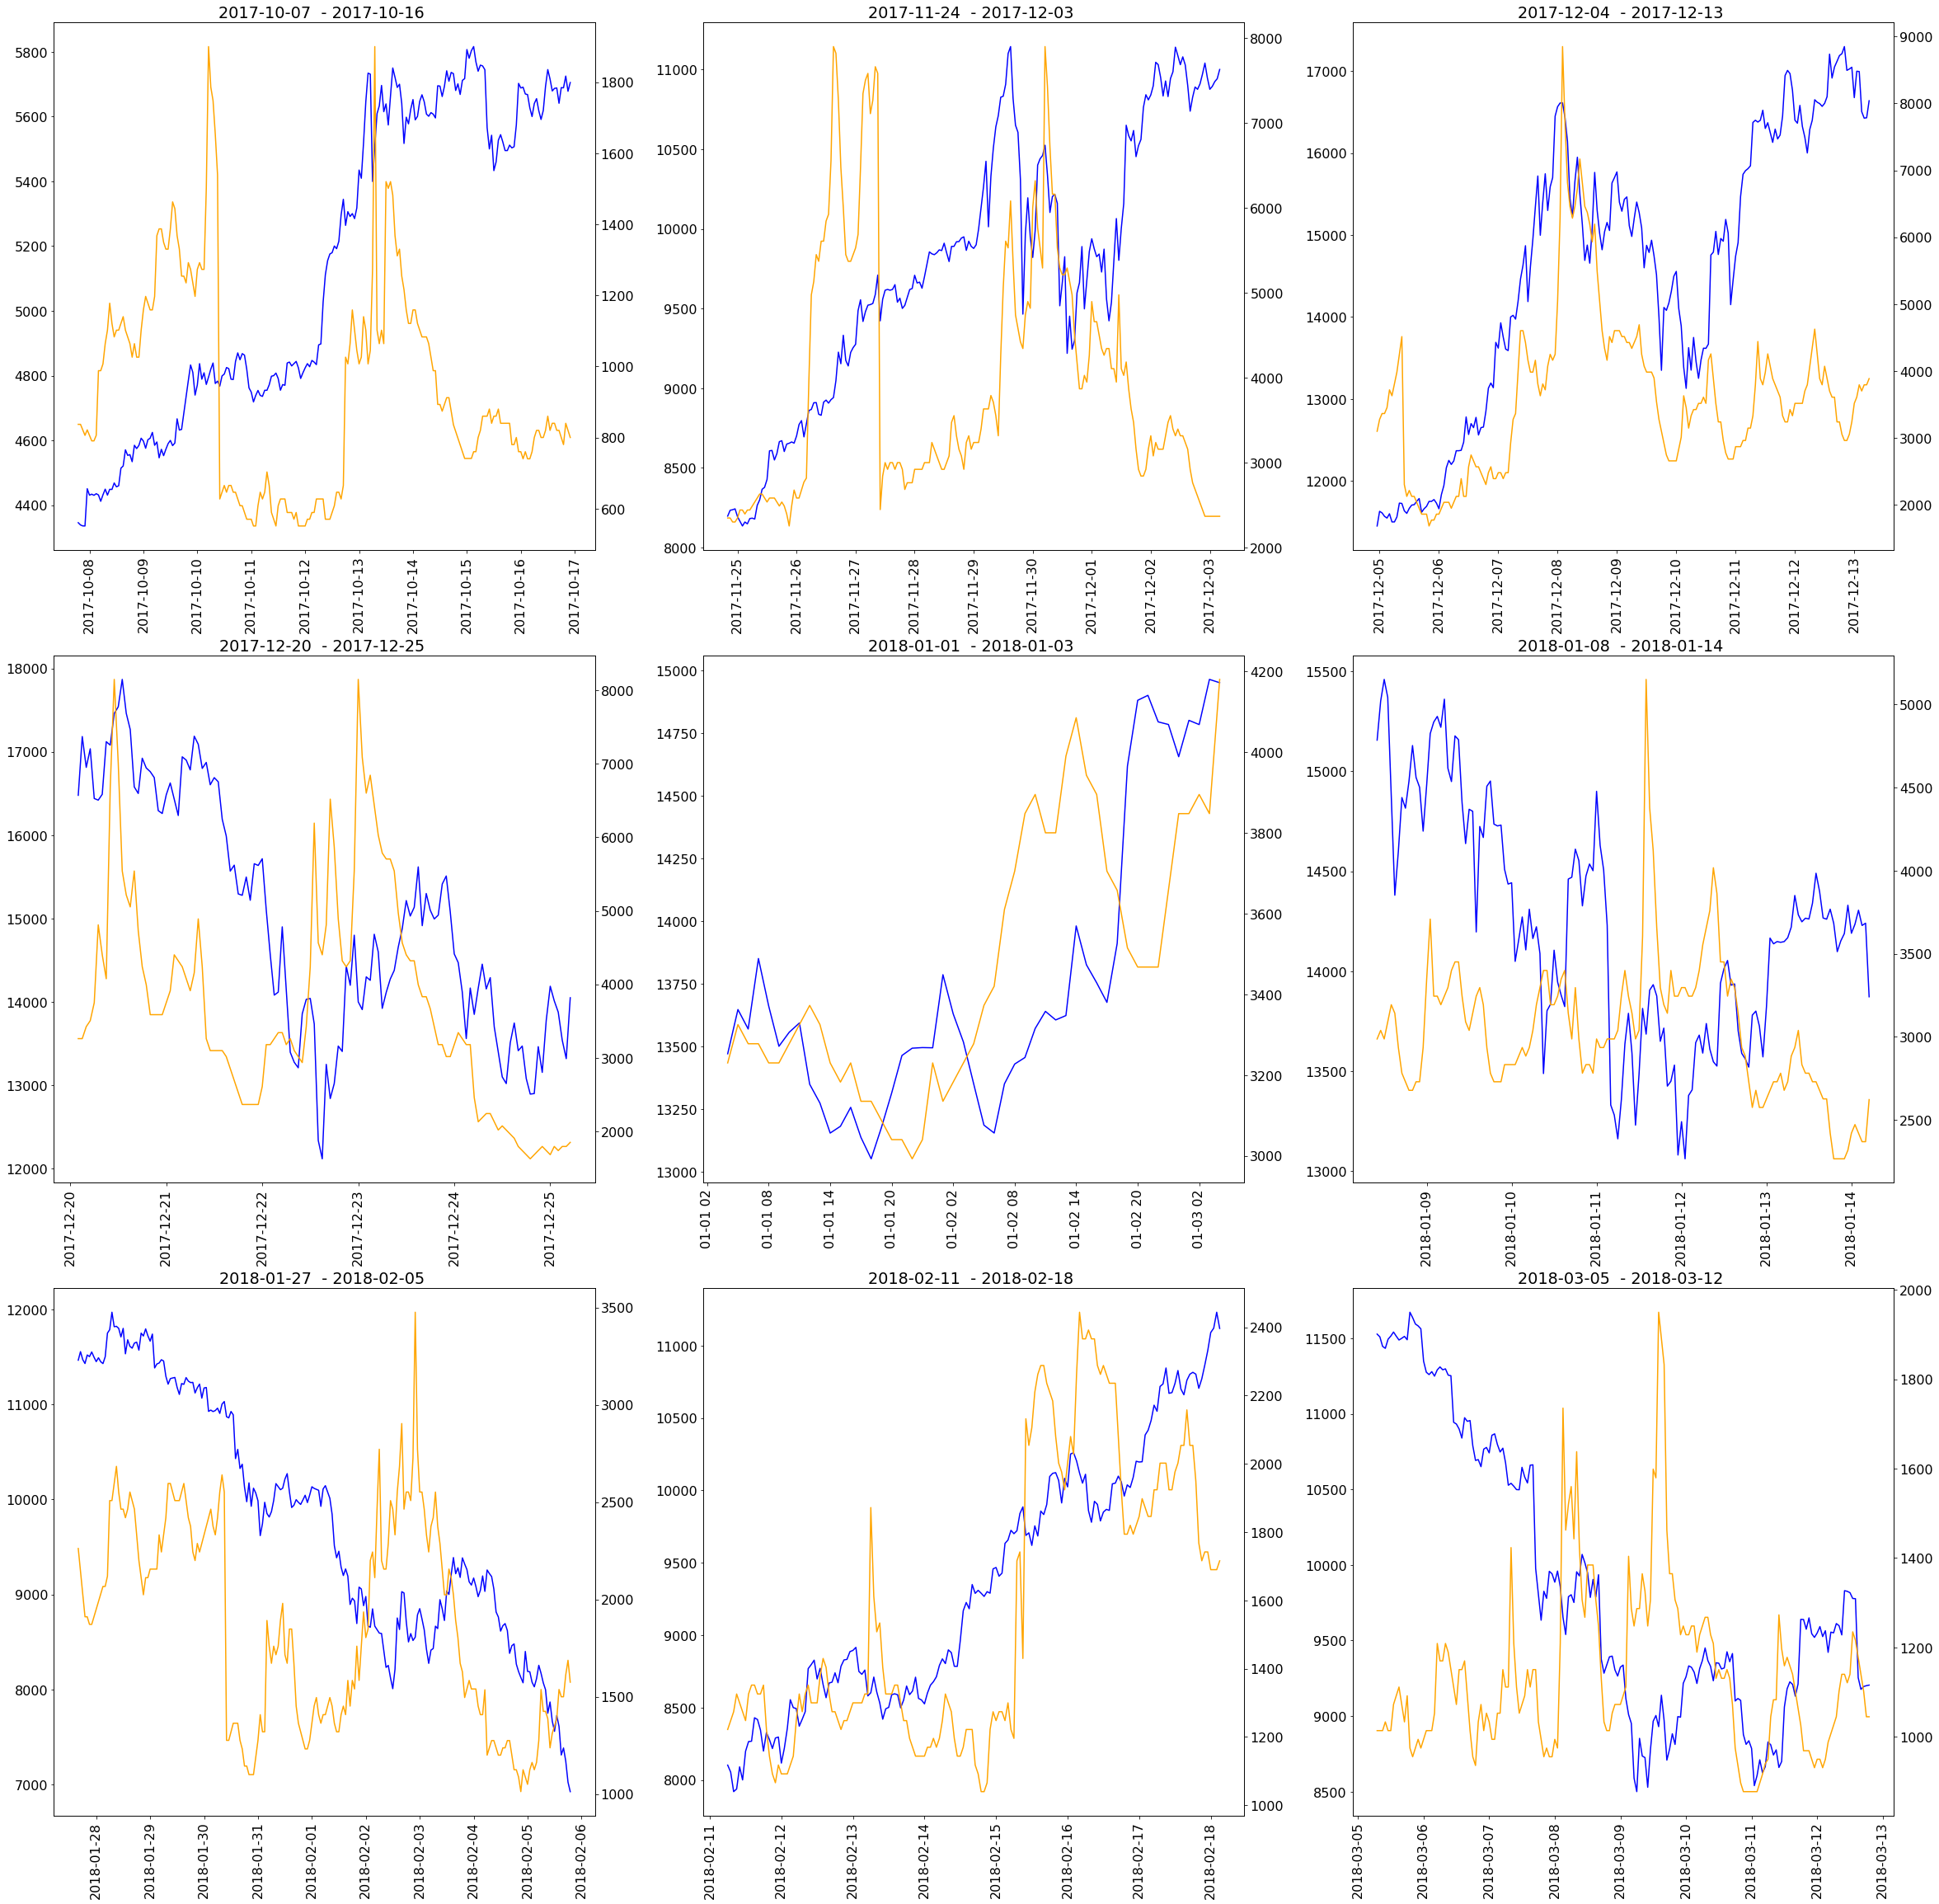

In [63]:
# plots all the anomalies

fig2, axes2 = plt.subplots(nrows=3, ncols=3, figsize=(40,40), sharex=False, sharey=False)

#for i, anomaly in enumerate(anomalies):
for i, ax in enumerate(axes2.flatten()):    
    time_period = anomalies[i].get_time_window()
    start_timestamp = time_period[0]
    end_timestamp = time_period[1] 
        
    in_range_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly["Timestamp"] <= end_timestamp) ]
    #display(in_range_df)
    ax.plot(in_range_df["Date(UTC)"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date(UTC)"], in_range_df["Bitcoin (Adj.)"], color='orange' )
    ax.set_title(str(in_range_df["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(in_range_df["Date(UTC)"].iloc[-1])[:-8] )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
fig.tight_layout()
fig.subplots_adjust(hspace=2)
plt.show();

# Blue is Price, Orange is Trend. 

In [ ]:
# to do: find out when google trend data had anomalies 